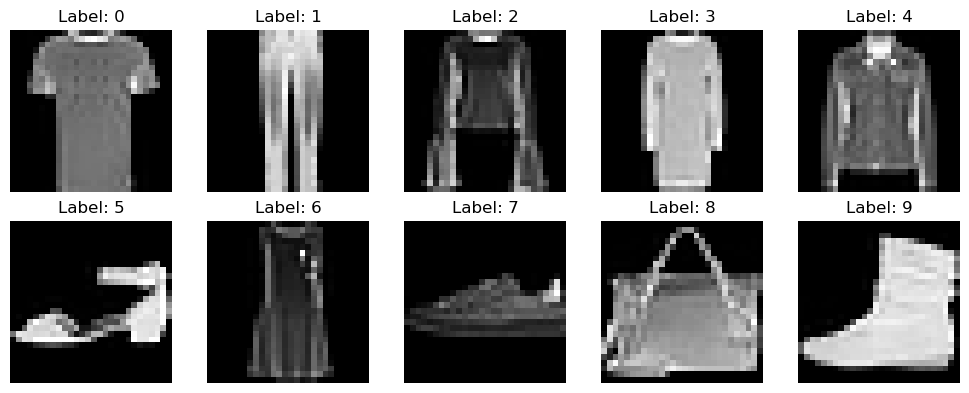

       label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0          6       0       0       0       0       0       0       0       0   
1          8       0       0       0       0       0       0       0       0   
2          9       0       0       0       0       0       0       0       0   
3          0       0       0       0       1       0       0       0       0   
4          0       0       0       0       0       0       1       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
47995      2       0       0       0       0       0       0       0       0   
47996      9       0       0       0       0       0       0       0       0   
47997      7       0       0       0       0       0       0       0       0   
47998      0       0       0       0       0       0       0      17      99   
47999      3       0       0       0       0       0       0       0       0   

       pixel9  ...  pixel775  pixel776 

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder


# Load the fixed CSV
df = pd.read_csv("fashion-mnist_train.csv")

# Group by class label
grouped = df.groupby("label")

# Prepare empty lists for train and test splits
train_list = []
test_list = []

# Split each class group into 80% train and 20% test
for label, group in grouped:
    train_split, test_split = train_test_split(
        group, 
        test_size=0.2, 
        random_state=42, 
        shuffle=True,
        stratify=None  # We are already splitting by class manually
    )
    train_list.append(train_split)
    test_list.append(test_split)

# Concatenate all class-wise splits
train_df = pd.concat(train_list).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat(test_list).sample(frac=1, random_state=42).reset_index(drop=True)


# One example per class
examples = train_df.groupby("label").first().reset_index()

# Plot
plt.figure(figsize=(10, 4))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    img = examples.loc[i].drop("label").values.astype(np.uint8).reshape(28, 28)
    plt.imshow(img, cmap="gray")
    plt.title(f"Label: {examples.loc[i, 'label']}")
    plt.axis("off")

plt.tight_layout()
plt.show()
print(train_df)
print(test_df)


Epoch 0: Loss = 2.3007, Train Acc = 16.45%, Test Acc = 16.42%
Time: 1.31s | Est. Remaining: 13.08 min
Epoch 10: Loss = 1.6959, Train Acc = 42.97%, Test Acc = 42.72%
Time: 1.11s | Est. Remaining: 10.95 min
Epoch 20: Loss = 1.7621, Train Acc = 41.23%, Test Acc = 41.28%
Time: 1.38s | Est. Remaining: 13.30 min
Epoch 30: Loss = 0.9094, Train Acc = 60.24%, Test Acc = 59.69%
Time: 1.21s | Est. Remaining: 11.48 min
Epoch 40: Loss = 0.7225, Train Acc = 70.40%, Test Acc = 70.48%
Time: 2.36s | Est. Remaining: 21.94 min
Epoch 50: Loss = 0.6674, Train Acc = 73.94%, Test Acc = 73.67%
Time: 1.54s | Est. Remaining: 14.12 min
Epoch 60: Loss = 0.6462, Train Acc = 74.74%, Test Acc = 74.62%
Time: 1.86s | Est. Remaining: 16.74 min
Epoch 70: Loss = 0.5969, Train Acc = 78.49%, Test Acc = 78.06%
Time: 1.08s | Est. Remaining: 9.52 min
Epoch 80: Loss = 0.6519, Train Acc = 76.05%, Test Acc = 75.69%
Time: 1.21s | Est. Remaining: 10.45 min
Epoch 90: Loss = 0.5956, Train Acc = 76.94%, Test Acc = 76.49%
Time: 1.06s 

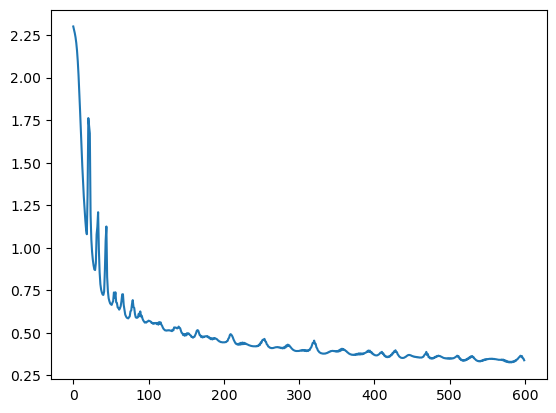

In [6]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Activation Functions
def ReLU(x):
    return np.maximum(0, x)

def ReLU_D(x):
    return np.where(x > 0, 1, 0)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_D(a):
    return a * (1 - a)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)



# Dataset preparation
X_train = train_df.drop("label", axis=1).values / 255.0
y_train = train_df["label"].values.reshape(-1, 1)
X_test = test_df.drop("label", axis=1).values / 255.0
y_test = test_df["label"].values.reshape(-1, 1)

encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)


# Normalize
mean = np.mean(X_train)
std = np.std(X_train)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# Network architecture
layers = [X_train.shape[1], 200, 100, 60, 30, 10]
activation = ['ReLU', 'ReLU', 'ReLU', 'ReLU', 'softmax']

# Initialize weights and biases separately
def init_weights(layers, activation):
    weights = {}
    biases = {}
    for i in range(1, len(layers)):
        if activation[i - 1] == "ReLU":
            weights[f"W{i}"] = np.random.randn(layers[i - 1], layers[i]) * np.sqrt(2 / layers[i - 1])
        elif activation[i - 1] == "sigmoid":
            weights[f"W{i}"] = np.random.randn(layers[i - 1], layers[i]) * np.sqrt(1 / layers[i - 1])
        else:  # softmax
            weights[f"W{i}"] = np.random.randn(layers[i - 1], layers[i]) * 0.01
        biases[f"b{i}"] = np.zeros((1, layers[i]))
    return weights, biases

# Forward pass
def forward_pass(X, weights, biases, activation):
    cache = {"A0": X}
    A = X
    for i in range(1, len(activation) + 1):
        Z = np.dot(A, weights[f"W{i}"]) + biases[f"b{i}"]
        if activation[i - 1] == "ReLU":
            A = ReLU(Z)
        elif activation[i - 1] == "sigmoid":
            A = sigmoid(Z)
        elif activation[i - 1] == "softmax":
            A = softmax(Z)
        cache[f"Z{i}"] = Z
        cache[f"A{i}"] = A
    return A, cache

# Backward pass
def backward_pass(y_true, weights, biases, cache, activation):
    grads = {}
    m = y_true.shape[0]
    L = len(activation)
    dZ = cache[f"A{L}"] - y_true

    for i in reversed(range(1, L + 1)):
        A_prev = cache[f"A{i - 1}"]
        grads[f"dW{i}"] = np.dot(A_prev.T, dZ) / m
        grads[f"db{i}"] = np.sum(dZ, axis=0, keepdims=True) / m
        if i > 1:
            dA_prev = np.dot(dZ, weights[f"W{i}"].T)
            if activation[i - 2] == "ReLU":
                dZ = dA_prev * ReLU_D(cache[f"Z{i - 1}"])
            elif activation[i - 2] == "sigmoid":
                dZ = dA_prev * sigmoid_D(cache[f"A{i - 1}"])
    return grads

# Update weights and biases
def update_weights(weights, biases, grads, lr):
    for key in weights:
        weights[key] -= lr * grads["d" + key]
    for key in biases:
        biases[key] -= lr * grads["d" + key]
    return weights, biases

# Accuracy
def accuracy(X, y, weights, biases, activation):
    y_pred, _ = forward_pass(X, weights, biases, activation)
    predictions = np.argmax(y_pred, axis=1)
    true_labels = np.argmax(y, axis=1)
    return np.mean(predictions == true_labels)

# Training
def train(X, y, layers, activation, epochs=600, lr=0.1, lemda=0.1):
    weights, biases = init_weights(layers, activation)
    loss_history = []
    m = X.shape[0]
    start_train = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()
        y_pred, cache = forward_pass(X, weights, biases, activation)

        L_loss = -np.sum(y * np.log(y_pred + 1e-9)) / m
        reg = (lemda / (2 * m)) * sum(np.sum(weights[f"W{i}"] ** 2) for i in range(1, len(layers)))
        loss = L_loss + reg

        grads = backward_pass(y, weights, biases, cache, activation)

        for i in range(1, len(layers)):
            grads[f"dW{i}"] += (lemda / m) * weights[f"W{i}"]

        weights, biases = update_weights(weights, biases, grads, lr)
        loss_history.append(loss)

        epoch_end = time.time()
        time_per_epoch = epoch_end - epoch_start
        time_remaining = (epochs - epoch - 1) * time_per_epoch

        if epoch % 10 == 0 or epoch == epochs - 1:
            train_acc = accuracy(X, y, weights, biases, activation)
            test_acc = accuracy(X_test, y_test_encoded, weights, biases, activation)
            print(f"Epoch {epoch}: Loss = {loss:.4f}, Train Acc = {train_acc*100:.2f}%, Test Acc = {test_acc*100:.2f}%")
            print(f"Time: {time_per_epoch:.2f}s | Est. Remaining: {time_remaining/60:.2f} min")

    total_time = time.time() - start_train
    print(f"\nTraining completed in {total_time / 60:.2f} minutes.")
    return weights, biases, loss_history

# Train the model
weights_trained, biases_trained, loss_history = train(X_train, y_train_encoded, layers, activation, epochs=600, lr=0.1, lemda=0.1)

# Final accuracy
train_accuracy = accuracy(X_train, y_train_encoded, weights_trained, biases_trained, activation)
print("Final Train Accuracy:", round(train_accuracy * 100, 2), "%")

test_accuracy = accuracy(X_test, y_test_encoded, weights_trained, biases_trained, activation)
print("Final Test Accuracy:", round(test_accuracy * 100, 2), "%")

# Plot loss
plt.plot(loss_history)



In [5]:
print("Best weights for layer 1:\n", weights_trained["W1"])
print("Best biases for layer 1:\n", biases_trained["b1"])


Best weights for layer 1:
 [[-0.02765531  0.03065758 -0.0339043  ... -0.04264737 -0.01403758
   0.00541057]
 [ 0.02432787 -0.05891693 -0.01995203 ... -0.01536993  0.01469839
  -0.02518497]
 [ 0.0088365   0.11703536 -0.04026775 ...  0.02275202  0.00720551
   0.04016316]
 ...
 [-0.04533769 -0.02261186  0.01584383 ... -0.00783665 -0.04505859
  -0.04688033]
 [-0.1195511   0.00207959 -0.02644063 ...  0.05968415  0.03351197
   0.0038155 ]
 [ 0.03794192 -0.01315931  0.0014108  ...  0.15211849  0.04307884
  -0.0610501 ]]
Best biases for layer 1:
 [[ 9.85706646e-03  4.62631030e-03 -7.76107018e-04 -2.70711325e-03
   2.03783520e-03 -1.97585430e-03  9.63914678e-03 -1.87638555e-03
   3.11596995e-03  1.25187919e-02 -7.56378787e-04  2.13617325e-04
   2.31566960e-03  1.02552716e-03 -2.83776195e-03 -7.51131231e-04
   9.69029945e-03  5.52251130e-03  6.81975463e-05  2.36025566e-03
   3.84334492e-04  7.03280919e-03  2.02000188e-03 -3.99114743e-03
  -2.07239552e-03 -2.93598137e-03  1.38588164e-03  5.049439

In [4]:

test_df = pd.read_csv("fashion-mnist_test.csv")
X_test = test_df.drop("label", axis=1).values / 255.0
y_test = test_df["label"].values.reshape(-1, 1)

X_test = (X_test - mean) / std

y_test_encoded = encoder.transform(y_test)

f_output, _ = forward_pass(X_test, weights_trained, biases_trained, activation)

f_acc = accuracy(X_test, y_test_encoded, weights_trained, biases_trained, activation)
print(f"Final Accuracy : {f_acc * 100:.2f}%")
print("Final Cost :", [loss_history[-1]])


NameError: name 'pd' is not defined